In [1]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc
#from google.colab import drive
#drive.mount('/content/drive')
# !ls "/content/drive/MyDrive"


2024-03-25 11:39:59.817374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 11:40:00.453784: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 11:40:00.457152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 11:40:02.655992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = '/home/johnm100/researchproject/Undergrad-Research/examples/examples/data/'
def load_data():
    total_data = 399
    offset = 50
    x_img_train = np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset,0:-1].astype('float32')
    x_img_test = np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:,0:-1].astype('float32')
    x_fea_train = np.genfromtxt(path +'ffea_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset].astype('float32')
    x_fea_test = np.genfromtxt(path + 'ffea_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:].astype('float32')
    y_lab_train = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=',')[0:total_data-offset], num_classes=2)
    y_lab_test = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=',')[total_data-offset-1:], num_classes=2)
    # reshape takes in the # of images, the dimensions we want (5, 5) and the # of channels (1)
    return((x_img_train.reshape(len(x_img_train), 5, 5, 1), x_img_test.reshape(len(x_img_test), 5, 5, 1)),
           (x_fea_train, x_fea_test), (y_lab_train, y_lab_test))

In [3]:
def make_model(_img_train, _fea_train):
    img_inputs = keras.layers.Input(shape=_img_train.shape[1:], name='image_input')
    # kernal size is the dimensions of the scanning matrix (weights) that will form the filter
    conv1 = keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='conv1')(img_inputs)
    conv2 = keras.layers.Conv2D(9, kernel_size=(2,2), activation='relu', name='conv2')(conv1)
    pool = keras.layers.MaxPooling2D((2, 2))(conv2)
    flat = keras.layers.Flatten()(pool)

    fea_inputs = keras.layers.Input(shape=_fea_train.shape[1:], name='feature_input')
    dense1 = keras.layers.Dense(3, activation='relu', name='dense1')(fea_inputs)

    concat = keras.layers.Concatenate(name='combined')([flat, dense1])
    output = keras.layers.Dense(2, activation='softmax', name='outputs')(concat)

    model = keras.models.Model(inputs=[img_inputs, fea_inputs], outputs=output, name='model')
    # keras.utils.plot_model(model, show_shapes=True)
    return model

In [4]:
((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data()


(349, 5, 5, 1)
(349, 7)
(349, 2)


/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


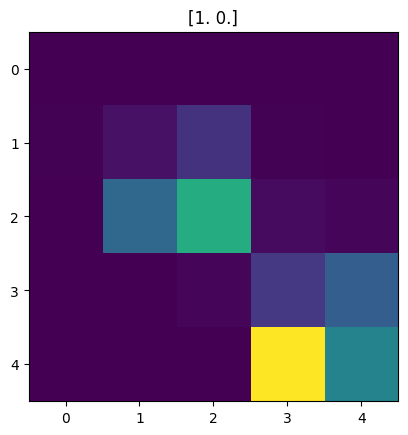

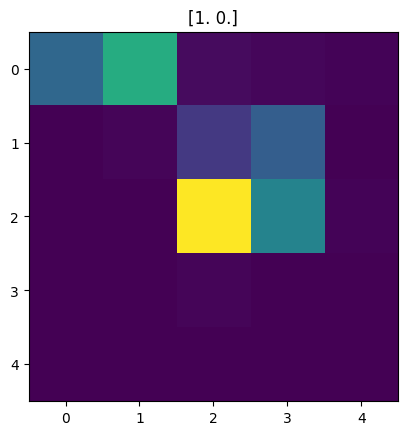

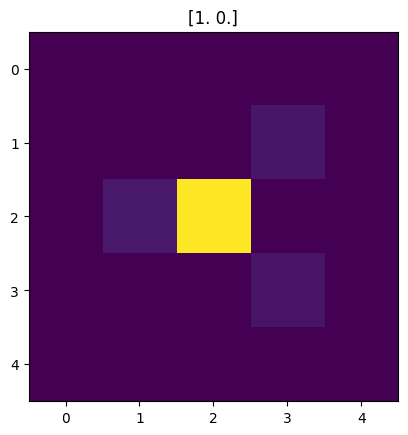

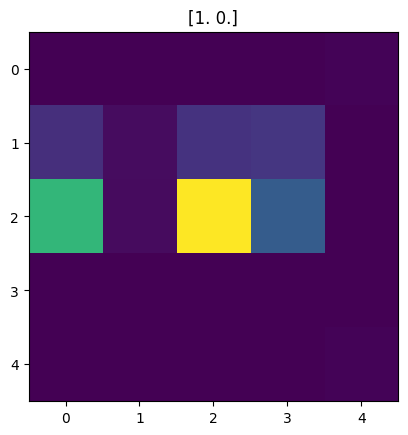

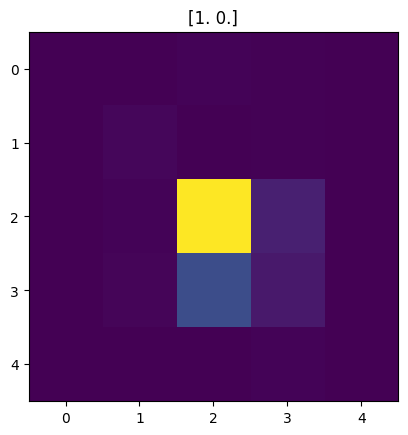

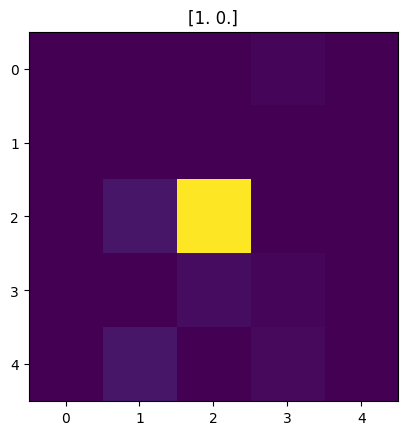

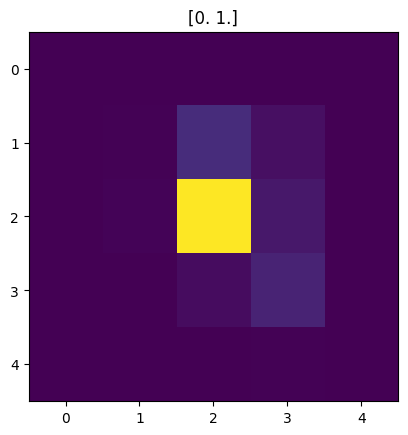

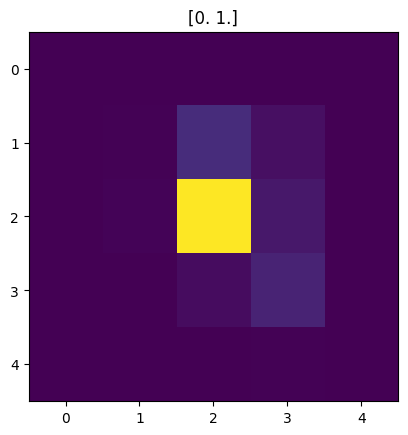

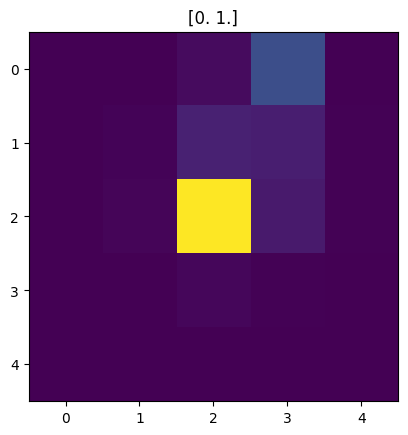

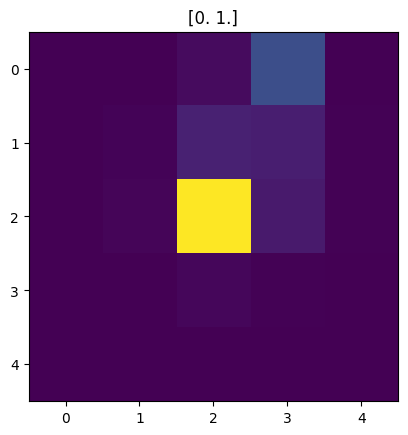

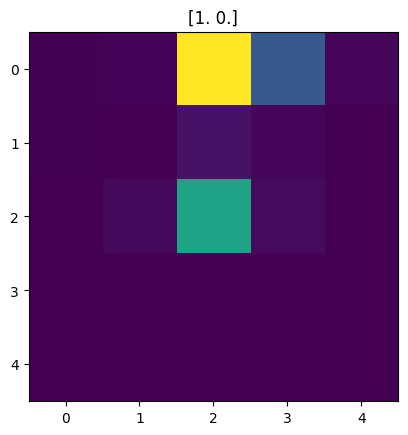

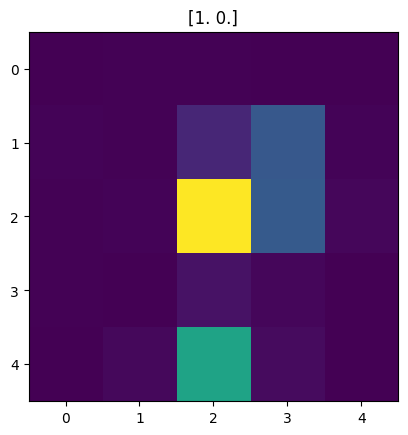

In [5]:
print(img_train.shape)
print(fea_train.shape)
print(y_lab_train.shape)
for i, data in enumerate(zip(img_train, y_lab_train)):
  img, label = data
  plt.imshow(img)
  plt.title(label)
  plt.show()
  if i>10:
    break

In [6]:
model = make_model(img_train, fea_train)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
22/22 [==============================] - 1s 15ms/step - loss: 0.5446 - accuracy: 0.6877 - val_loss: 0.5312 - val_accuracy: 0.6923
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.5133 - accuracy: 0.7077 - val_loss: 0.5199 - val_accuracy: 0.6923
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.4823 - accuracy: 0.7450 - val_loss: 0.5041 - val_accuracy: 0.7308
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.4591 - accuracy: 0.7708 - val_loss: 0.4952 - val_accuracy: 0.7308
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4399 - accuracy: 0.8023 - val_loss: 0.4882 - val_accuracy: 0.7692
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4236 - accuracy: 0.8195 - val_loss: 0.4761 - val_accuracy: 0.7885
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4039 - accuracy: 0.8309 - val_loss: 0.4743 - val_accuracy: 0.8077
Epoch 8/100


<Axes: >

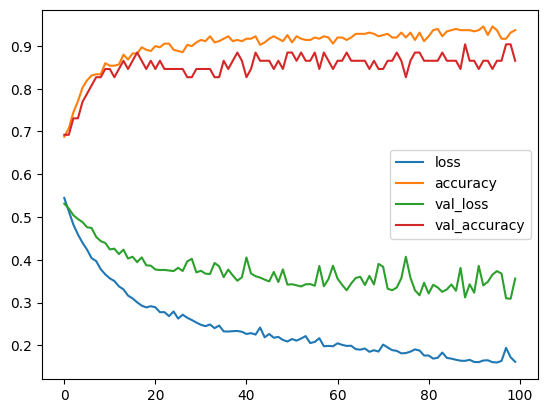

In [7]:
history = model.fit(x=[img_train, fea_train], y=y_lab_train, batch_size=16,
        validation_data=([img_test, fea_test], y_lab_test), epochs=100)
vals = pd.DataFrame(history.history)
vals.plot()

In [8]:
dataset = (np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter = ',').astype('float32')).reshape(400, 1)
d = (np.genfromtxt(path + 'fimg_pi0_10-15gev.csv', delimiter = ',')[:, 0:-1].astype('float32')).reshape(400, 25)
r = np.append(d, dataset, axis=1) # .reshape(400, 2, 1)
np.savetxt('output.txt', r, delimiter=',', fmt='%s')

In [9]:
input_data = [img_test,fea_test] #input of img_test and fea_test
pred = model.predict(input_data) #Makes the model make its predictions on the input
threshold = 0.5 
binary_pred = np.where(pred>threshold,1,0) #This line and the one before gives a threshold value that will cause the prediction to be rounded

#I assume that we are using the rounding method to see if the prediction should be a '1.0' or a '0.1'
#therefore, I used the threshold = 0.5 and np.where to make the set of predictions

binary_pred = np.argmax(binary_pred, axis=1)
pred_state = np.where(binary_pred == 0, 1, 0)

y_lab_test = np.argmax(y_lab_test, axis=1)
y_lab_test_state = np.where(y_lab_test == 0,1,0)

y_lab_train = np.argmax(y_lab_train, axis=1)
y_lab_train_state = np.where(y_lab_train == 0,1,0)

#The code above converts [1,0] and [0,1] into 1 and 0 (states) by looking at the position of the maximum number. If the 1 is in the first position, 
#the element is turned into a 1. If the 1 is in the 2nd position, the element is converted into a 0. 

2/2 [==============================] - 0s 3ms/step


[[34  2]
 [ 5 11]]
Confusion Matrix:


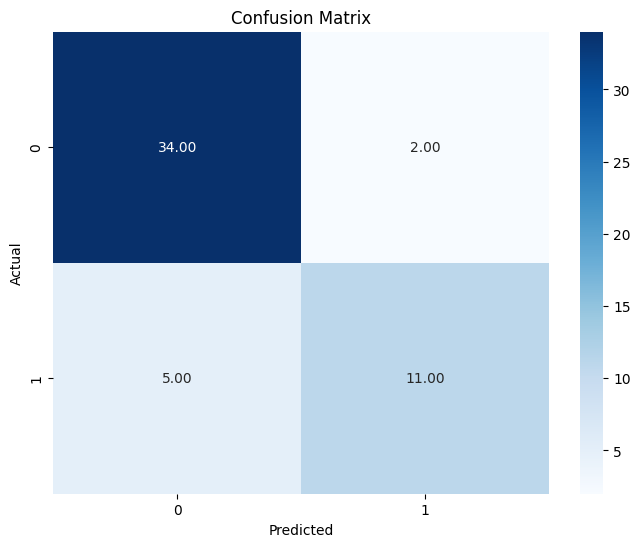

In [10]:
cm = confusion_matrix(y_lab_test_state, pred_state)

print(cm)
# Display the confusion matrix
print("Confusion Matrix:")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_lab_test), yticklabels=np.unique(y_lab_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
incorrect_indeces = np.where(y_lab_test_state != pred_state)
print(incorrect_indeces)


#The code above is made to show the indices of the elements where y_lab_test_state and pred_state are not in agreement. 


(array([ 0, 10, 11, 13, 19, 41, 44]),)


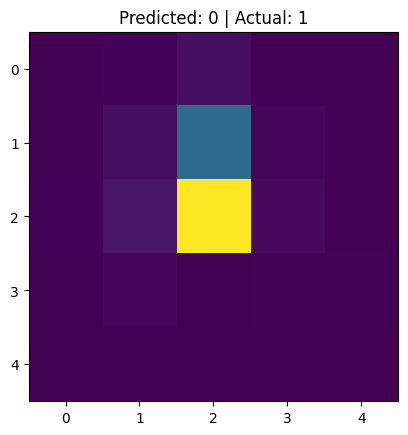

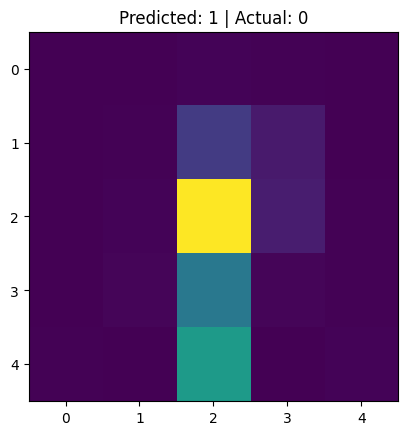

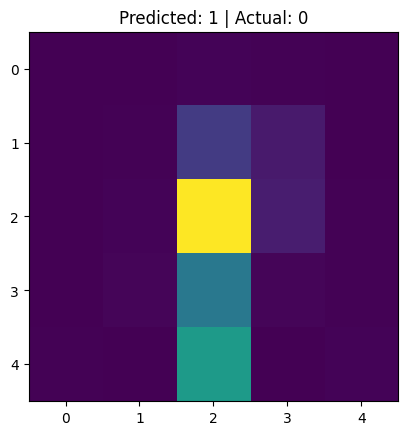

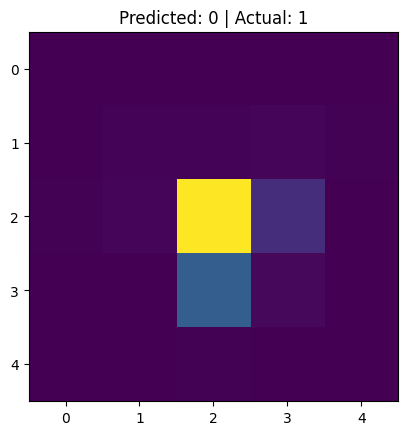

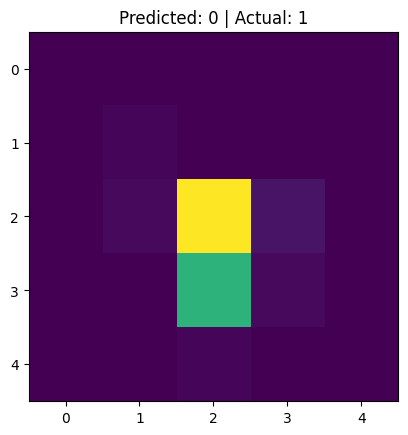

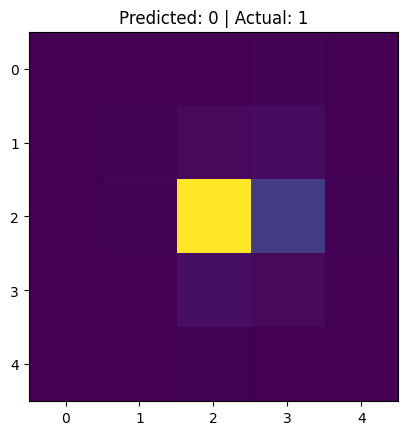

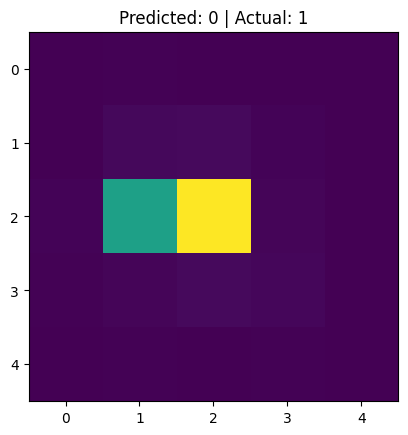

In [12]:
#The purpose of this cell is to print out the images associated with where y_lab_test_state and pred_state don't agree
#The output is the images that the model got wrong, labeled with the predicted vs actual state
for i, data in enumerate(zip(img_test, y_lab_test_state,pred_state)):
    img, true_label ,pred_label = data

    if np.any(i == np.array(incorrect_indeces)):
        plt.imshow(img)
        plt.title(f'Predicted: {pred_label} | Actual: {true_label}')
        plt.show()




In [13]:
#The code in this cell has been made to display the number of 1's and 0's in the training vs testing datasets. 
#The proportions are not the same. The training data has more 0's and the testing data has more 1's. 
#The model is likely overtraining on 0's and undertraining on 1's. 
#This is why the inaccuracies in the testing phase is due mostly to the model's poor abilities to accurately predict 1's. 


def plot_combined_percentage_histogram(y_train, y_test):
    # Calculate the percentages of 1's and 0's in the training and testing data
    total_train = len(y_train)
    total_test = len(y_test)

    train_percentages = np.sum(y_train, axis=0) / total_train * 100
    test_percentages = np.sum(y_test, axis=0) / total_test * 100

    # Plotting combined histograms
    plt.figure(figsize=(8, 5))

    bar_width = 0.35
    index = np.arange(len(train_percentages))

    # Training data histogram
    plt.bar(index, train_percentages, bar_width, label='Training Data', color='blue')

    # Testing data histogram
    plt.bar(index + bar_width, test_percentages, bar_width, label='Testing Data', color='orange')

    plt.title('Combined Data Percentages')
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(index + bar_width / 2, ['Class 0', 'Class 1'])
    plt.legend()
    plt.show()

# Convert y_lab_train and y_lab_test to arrays
y_lab_train_array = np.array(y_lab_train)
y_lab_test_array = np.array(y_lab_test)

# Plot combined percentage histograms
plot_combined_percentage_histogram(y_lab_train_array, y_lab_test_array)

TypeError: object of type 'numpy.float64' has no len()

<Figure size 800x500 with 0 Axes>

In [ ]:
#From here forward, images of the signatures will be augmented so that seperated images are processed more appropriately. 

In [14]:
path = '/home/johnm100/researchproject/Undergrad-Research/examples/examples/data/'
def load_data(test_size = 0.1, augment_images = False):
    
    # import train test split
    from sklearn.model_selection import train_test_split

    # load the data
    x_img = np.genfromtxt(path+'fimg_pi0_10-15gev.csv', delimiter=',')[0:-1,0:-1].astype('float32').reshape(-1,5,5,1)
    x_fea = np.genfromtxt(path+'ffea_pi0_10-15gev.csv', delimiter=',')[0:-1,:].astype('float32')
    y_lab = keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_10-15gev.csv', delimiter=',')[0:-1], num_classes=2)
    
    x_img = np.append(x_img, np.genfromtxt(path+'fimg_pi0_20-25gev_1.csv', delimiter=',')[0:-1,0:-1].astype('float32').reshape(-1,5,5,1))
    x_fea = np.append(x_fea, np.genfromtxt(path+'ffea_pi0_20-25gev_1.csv', delimiter=',')[0:-1,:].astype('float32'))
    y_lab = np.append(y_lab, keras.utils.to_categorical(np.genfromtxt(path + 'fcls_pi0_20-25gev_1.csv', delimiter=',')[0:-1], num_classes=2))

    # reshape image data
    len_x_img = len(x_img)
    x_img = x_img.reshape(len_x_img, 5, 5, 1)

    # img_train = x_img
    # img_test = x_img
    # fea_train = x_fea
    # fea_test = x_fea
    # y_lab_train = y_lab
    # y_lab_test = y_lab
    

    if augment_images:
        # get the center of the image
        center = (2, 2)

        # pixels to keep mask
        pixels_to_keep = np.zeros((5, 5))

        # distances from the center
        distances = np.zeros((5, 5, 1))
        for j in range(5):
            for k in range(5):
                distance = np.sqrt((j - center[0])**2 + (k - center[1])**2)
                distances[j, k] = distance
        
        # arg sort the distances
        sorted_distances = np.argsort(distances, axis=None)

        # convert the labels to scalar for easy use
        y_lab_scalar = np.argmax(y_lab, axis=1)

        aug_x_img = []
        aug_y_label = []
        aug_x_fea = []

        for i in range(len(x_img)):
            if y_lab_scalar[i] == 1: # if the image is merged,
                continue
            
            # get the target energy
            seperated_energy = x_fea[i, 0]
            aug_x_fea.append(x_fea[i,:])
            aug_y_label.append(y_lab[i,:])
            aug_x_img.append(x_img[i,:])
            
            # sum the energy
            summed_energy = 0

            # loop over the pixels and sum the energy
            for sort_dist in sorted_distances:
                j, k = np.unravel_index(sort_dist, (5, 5))
                summed_energy += x_img[j, k, 0]
                pixels_to_keep[j, k] = 1
                if summed_energy > seperated_energy:
                    break

            # zero out all pixels not in the circle
            for j in range(5):
                for k in range(5):
                    if pixels_to_keep[j, k] == 0:
                        x_img[j, k, 0] = 0
        aug_x_fea = np.array(aug_x_fea)
        aug_x_img = np.array(aug_x_img)
        aug_y_label = np.array(aug_y_label)

        # x_fea = np.concatenate((x_fea,aug_x_fea))
        # x_img = np.concatenate((x_img,aug_x_img))
        # y_lab = np.concatenate((y_lab,aug_y_label))
    # split the data
    img_train, img_test, fea_train, fea_test, y_lab_train, y_lab_test = train_test_split(x_img, x_fea, y_lab, test_size=test_size, random_state=42)

    # return the data
    return((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test))

((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data(.1,True)
print(img_train.shape)

ValueError: cannot reshape array of size 19950 into shape (19950,5,5,1)

In [15]:
# get the location of the maximum value in the image
def max_location(img):
    max_loc = np.zeros((img.shape[0], 2))
    for i in range(img.shape[0]):
        max_loc[i] = np.unravel_index(np.argmax(img[i,:,:,0]), (5,5))
    return(max_loc)

In [16]:
# load the data
((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data()

scalar_y_lab_train = np.argmax(y_lab_train, axis=1)
scalar_y_lab_test = np.argmax(y_lab_test, axis=1)


sperated_samples = np.where(scalar_y_lab_train == 0)[0]
sperated_imgs = img_train[sperated_samples]
seperated_feas = fea_train [sperated_samples]
seperated_labels = y_lab_train[sperated_samples]
seperated_scalar_labels = scalar_y_lab_train[sperated_samples]

seperated_energy = fea_train[sperated_samples, 0]

max_loc_train = max_location(sperated_imgs)

ValueError: cannot reshape array of size 19950 into shape (19950,5,5,1)

NameError: name 'seperated_labels' is not defined

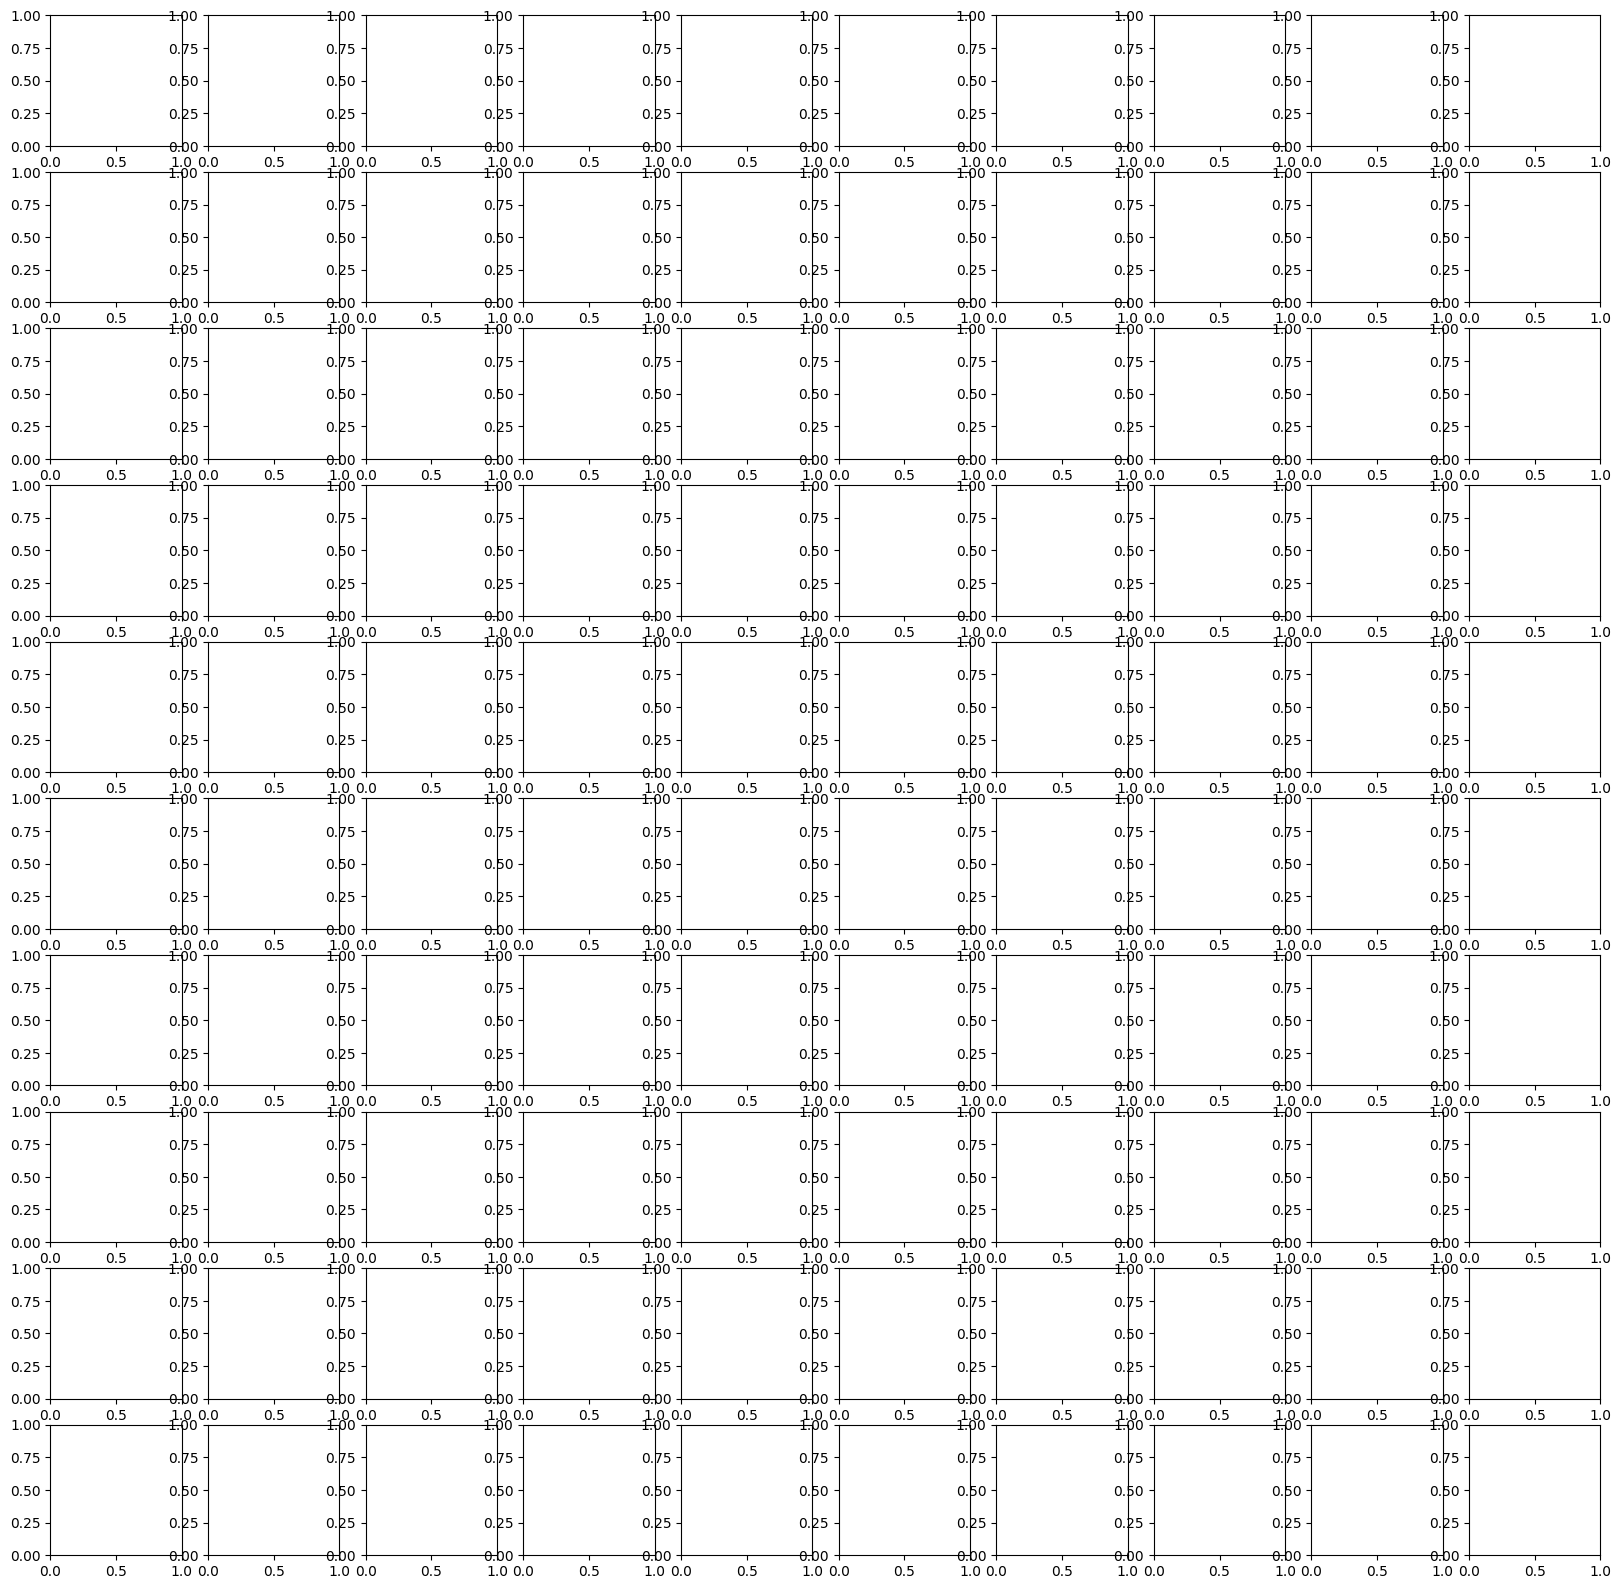

In [17]:

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.ravel()
for i, data in enumerate(zip(img_train, seperated_labels)):
    img, label = data
    ax[i].imshow(img[:,:,0], cmap='Reds')
    ax[i].set_title(f'label = {label}')
    ax[i].axis('off')

    # plot the max location
    ax[i].scatter(max_loc_train[i, 1], max_loc_train[i, 0], c='r')


    if i > 98:
        break
plt.show()

NameError: name 'sperated_imgs' is not defined

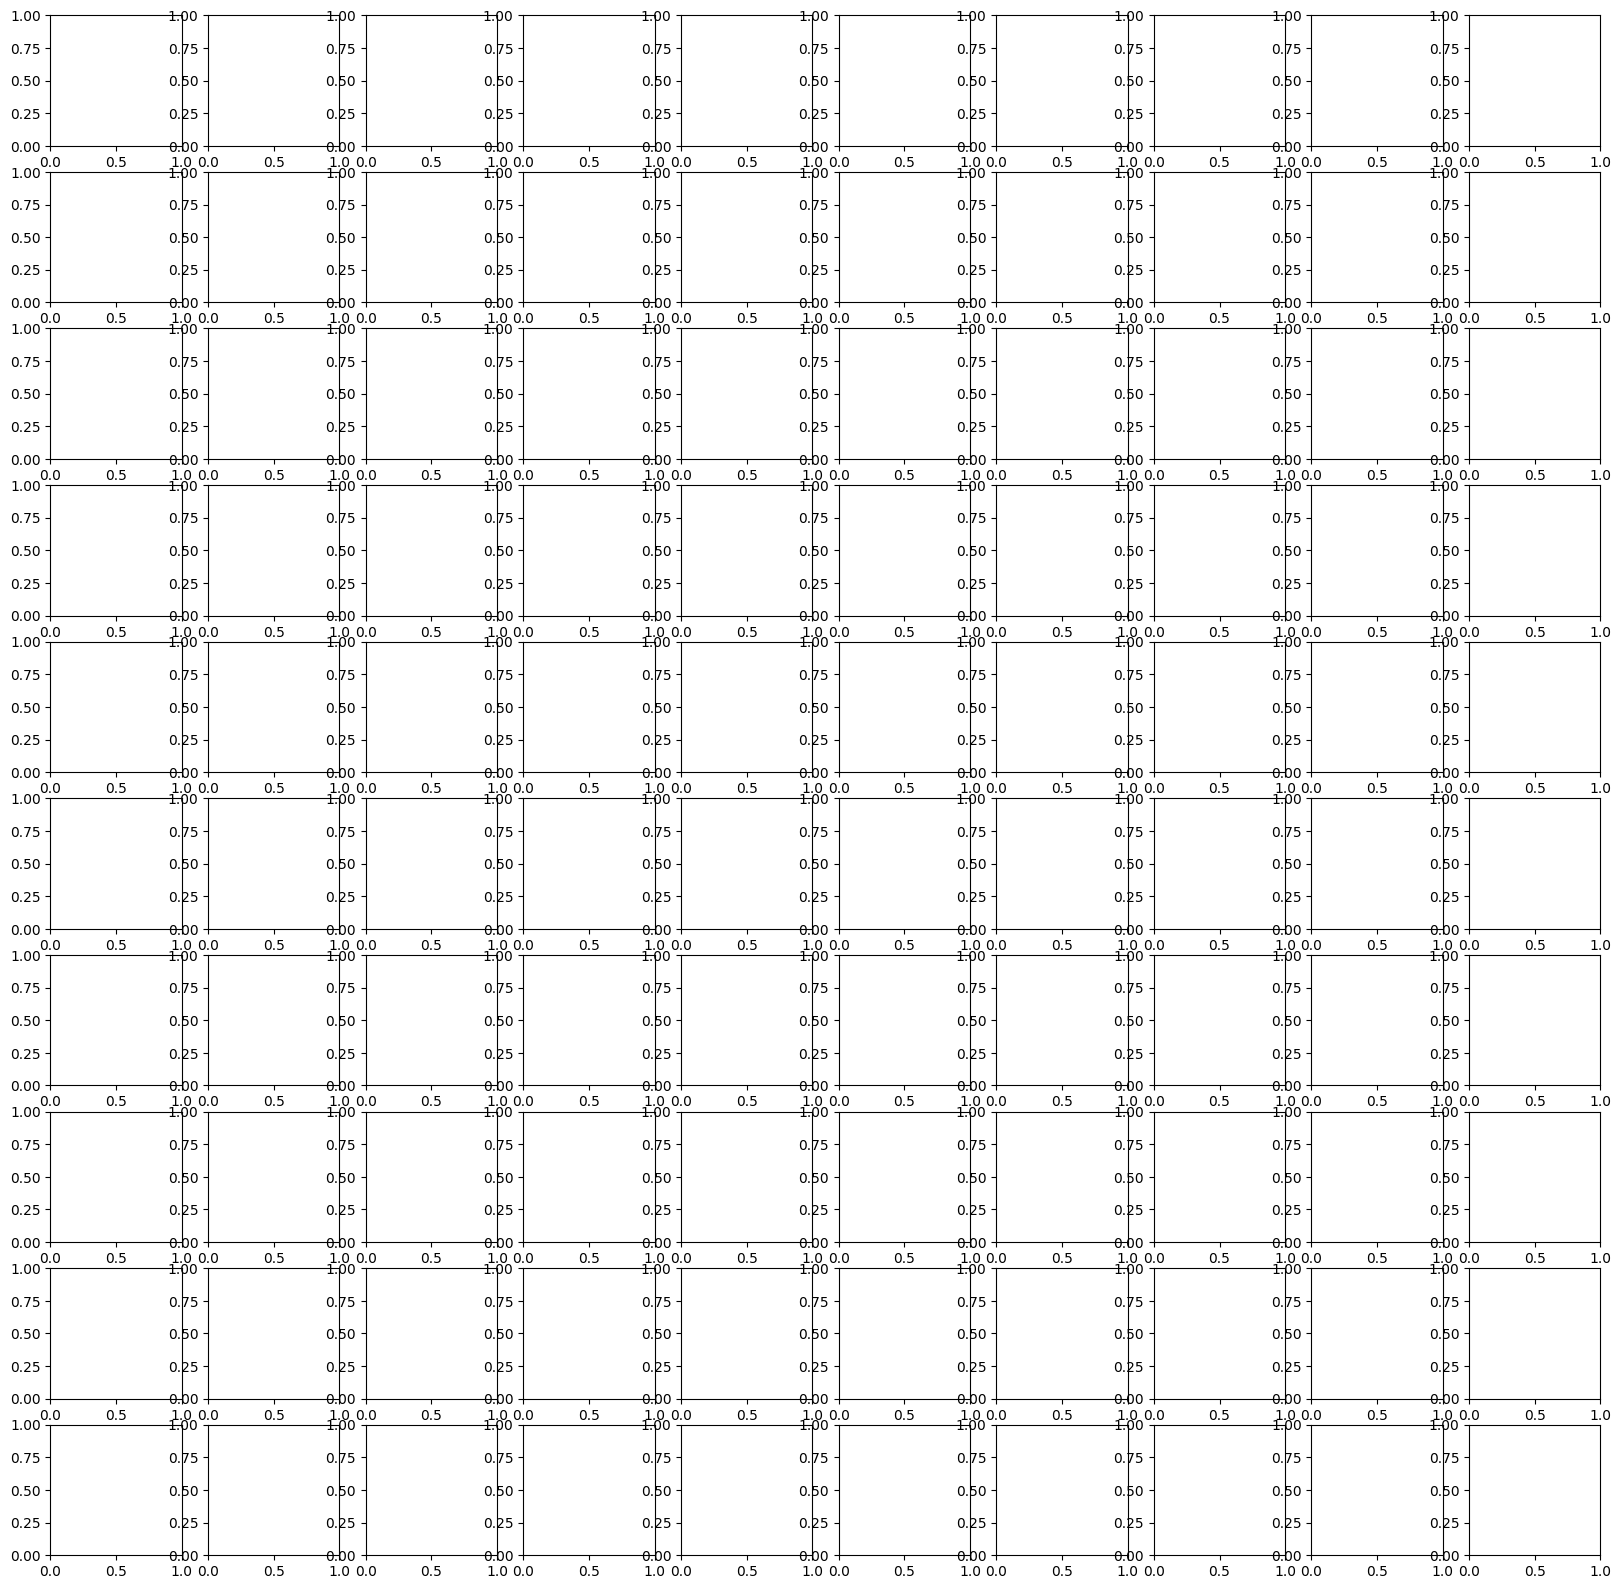

In [18]:
# plot the sperated images
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.ravel()
for i, data in enumerate(zip(sperated_imgs, seperated_scalar_labels)):
    img, label = data
    ax[i].imshow(img[:,:,0], cmap='Reds')
    ax[i].set_title(f'label = {label}')
    ax[i].axis('off')

    # plot the max location
    # ax[i].scatter(max_loc_train[sperated_samples[i], 1], max_loc_train[sperated_samples[i], 0], c='r')

    # get the center of the image
    center = (2, 2)
    ax[i].scatter(center[0], center[1], c='b')

    # pixels to keep
    pixels_to_keep = np.zeros((5, 5))

    # distances from the center
    distances = np.zeros((5, 5, 1))
    for j in range(5):
        for k in range(5):
            distance = np.sqrt((j - center[0])**2 + (k - center[1])**2)
            distances[j, k] = distance
        
    # arg sort the distances
    sorted_distances = np.argsort(distances, axis=None)

    summed_energy = 0
    # loop over the pixels and sum the energy
    for sort_dist in sorted_distances:
        j, k = np.unravel_index(sort_dist, (5, 5))
        summed_energy += img[j, k, 0]
        pixels_to_keep[j, k] = 1
        if summed_energy > seperated_energy[i]:
            break
    
    # zero out all pixels not in the circle
    for j in range(5):
        for k in range(5):
            if pixels_to_keep[j, k] == 0:
                img[j, k, 0] = 0
        
    ax[i].imshow(img, cmap='Reds')


    if i > 98:
        break
plt.show()

In [29]:
print(type(sperated_imgs))
print(type(seperated_scalar_labels))

print(sperated_imgs.shape)
print(seperated_scalar_labels.shape)

NameError: name 'sperated_imgs' is not defined

In [ ]:
#I am thinking that it would be possible to simply re-do the same steps with the new images and labels the same way the model 
#was initially built. 

In [19]:
def make_model(img_train, _fea_train):
    img_inputs = keras.layers.Input(shape=img_train.shape[1:], name='image_input')
    # kernal size is the dimensions of the scanning matrix (weights) that will form the filter
    conv1 = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='conv1')(img_inputs)
    pool = keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = keras.layers.Conv2D(9, kernel_size=(2,2), activation='relu', name='conv2')(conv1)
    pool_2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    flat = keras.layers.Flatten()(pool_2)

    fea_inputs = keras.layers.Input(shape=_fea_train.shape[1:], name='feature_input')
    dense1 = keras.layers.Dense(7, activation='relu', name='dense1')(fea_inputs)

    concat = keras.layers.Concatenate(name='combined')([flat, dense1])
    output = keras.layers.Dense(2, activation='softmax', name='outputs')(concat)

    model = keras.models.Model(inputs=[img_inputs, fea_inputs], outputs=output, name='model')
    # keras.utils.plot_model(model, show_shapes=True)
    return model

In [20]:
((img_train, img_test), (fea_train, fea_test), (y_lab_train, y_lab_test)) = load_data(.1, augment_images=True)

ValueError: cannot reshape array of size 19950 into shape (19950,5,5,1)

In [21]:
model = make_model(img_train, fea_train)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [22]:
history = model.fit(x=[img_train, fea_train], y=y_lab_train, batch_size=16,
        validation_data=([img_test, fea_test], y_lab_test), epochs=150)
vals = pd.DataFrame(history.history)
vals.plot()

Epoch 1/150


ValueError: in user code:

    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/johnm100/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [ ]:
#From Here will be an attempt to move the important parts of the images (places with nonzero signatures). They will be shifted so as to move them from their original positions, but not in a manner that makes nonzero signatures move out of bounds. 

In [23]:
def random_shift(img):
    
    nz_rows, nz_cols = np.nonzero(img) #This line of code obtains the coordinates of nonzero elements of the "heatmap" that represents each image

    # The two proceeding lines obtains the maximum allowable shift that can be executed in the 2D plane that the images sit in. It works by finding the lowest coordinates of the rows and columns (from np.min(nz_cols) and np.min(nz_rows)) and subtracting it from the maximum possible row/column index
    max_shift_x = min(np.min(nz_cols), img.shape[1] - np.max(nz_cols) - 1) 
    max_shift_y = min(np.min(nz_rows), img.shape[0] - np.max(nz_rows) - 1)

    # The code below simply generates random shifts with the randint method, which is constrained to the maximum x and y shifts, so as to not move important signatures out of bounds. 
    shift_x = np.random.randint(-max_shift_x, max_shift_x + 1)
    shift_y = np.random.randint(-max_shift_y, max_shift_y + 1)

    # The code below uses the "np.roll" method to move the elements along the allowable shifts, as determined by the previous constraints 
    shifted_img = np.roll(img, shift_x, axis=1)
    shifted_img = np.roll(shifted_img, shift_y, axis=0)

    return shifted_img

# The code below simply applies the function to each of the images. 
shifted_imgs = np.zeros_like(sperated_imgs)
for i, img in enumerate(sperated_imgs):
    shifted_imgs[i] = random_shift(img)

NameError: name 'sperated_imgs' is not defined